In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('Preprocessed_amazonScrape.csv')

In [3]:
df.drop(['Link','Image URL','Description'],axis=1,inplace=True)

My dataset has string representation of lists <br>
Thus using eval() function to evaluate a string as a Python expression.

In [4]:
df['positive_feedback'] = df['positive_feedback'].apply(lambda x: eval(x))
df['critical_feedback'] = df['critical_feedback'].apply(lambda x: eval(x))

#### Calculating number of positive and critical reviews per item

In [5]:
df['positive_count'] = df['positive_feedback'].apply(lambda x: len(x))
df['critical_count'] = df['critical_feedback'].apply(lambda x: len(x))

#### Calculating average positive and critical review length for a product

In [6]:
def avg_review_len(review_list):
    counter = len(review_list)
    avg = 0
    div = 0.001
    if counter != 0:
        for i in range(counter):
            avg += len(review_list[i])
        avg = avg/(counter + div)
        return round(avg)
    else :
        return 0
    

In [7]:
df['avg_p_review_len'] = df['positive_feedback'].apply(lambda x: avg_review_len(x))
df['avg_c_review_len'] = df['critical_feedback'].apply(lambda x: avg_review_len(x))

#### Assigning tags on the relative prices, This is with respect to specific item types

In [8]:
def cost_classifier(item_type):
    item_quantile_25 = df[df['item'] == item_type]['Price'].quantile(0.25)
    item_quantile_75 = df[df['item'] == item_type]['Price'].quantile(0.75)
    
    for index, row in df.iterrows():      # df.iterrows() to iterate through the rows
        if row['item'] == item_type:
            price = row['Price']
            if price <= item_quantile_25:
                df.loc[index, 'price_category'] = 'cheap'
            elif item_quantile_25 < price <= item_quantile_75:
                df.loc[index, 'price_category'] = 'moderate'
            else:
                df.loc[index, 'price_category'] = 'expensive'

item_types = df['item'].unique()
for i in item_types:
    cost_classifier(i)

### Price distributtion Viz across the product types 

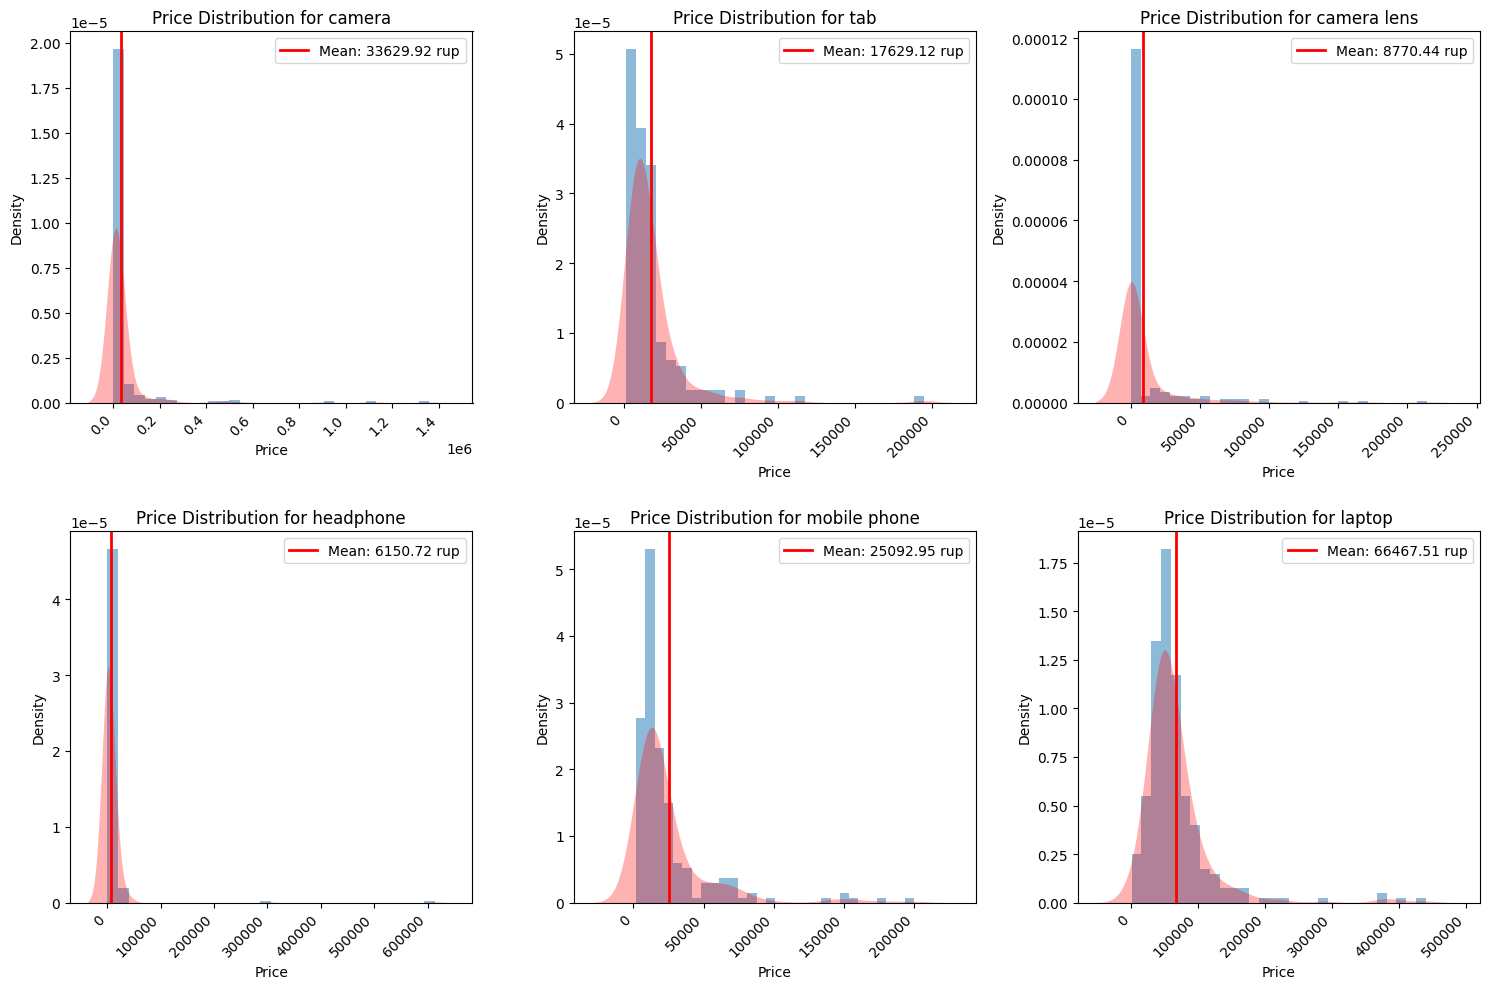

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))

for i in range(len(item_types)):
    row = i // 3  
    col = i % 3   
    
    axes[row, col].hist(df[df['item'] == item_types[i]]['Price'], bins=30, density=True, alpha=0.5)
    sns.kdeplot(df[df['item'] == item_types[i]]['Price'], ax=axes[row, col], color='r', fill=True, alpha=0.3, linewidth=0)        
    mean_price = df[df['item'] == item_types[i]]['Price'].mean()
    
    axes[row, col].axvline(mean_price, color='r', linestyle='-', linewidth=2, label=f'Mean: {mean_price:.2f} rup')
    
    axes[row, col].set_title(f'Price Distribution for {item_types[i]}')
    axes[row, col].set_xlabel('Price')
    axes[row, col].set_ylabel('Density')  # Adjust ylabel to reflect density
    axes[row, col].legend()  # Show legend with median and mean labels
    plt.setp(axes[row, col].get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.savefig('price_distribution.png')
plt.show()

## Histogram plot of review counts per item type

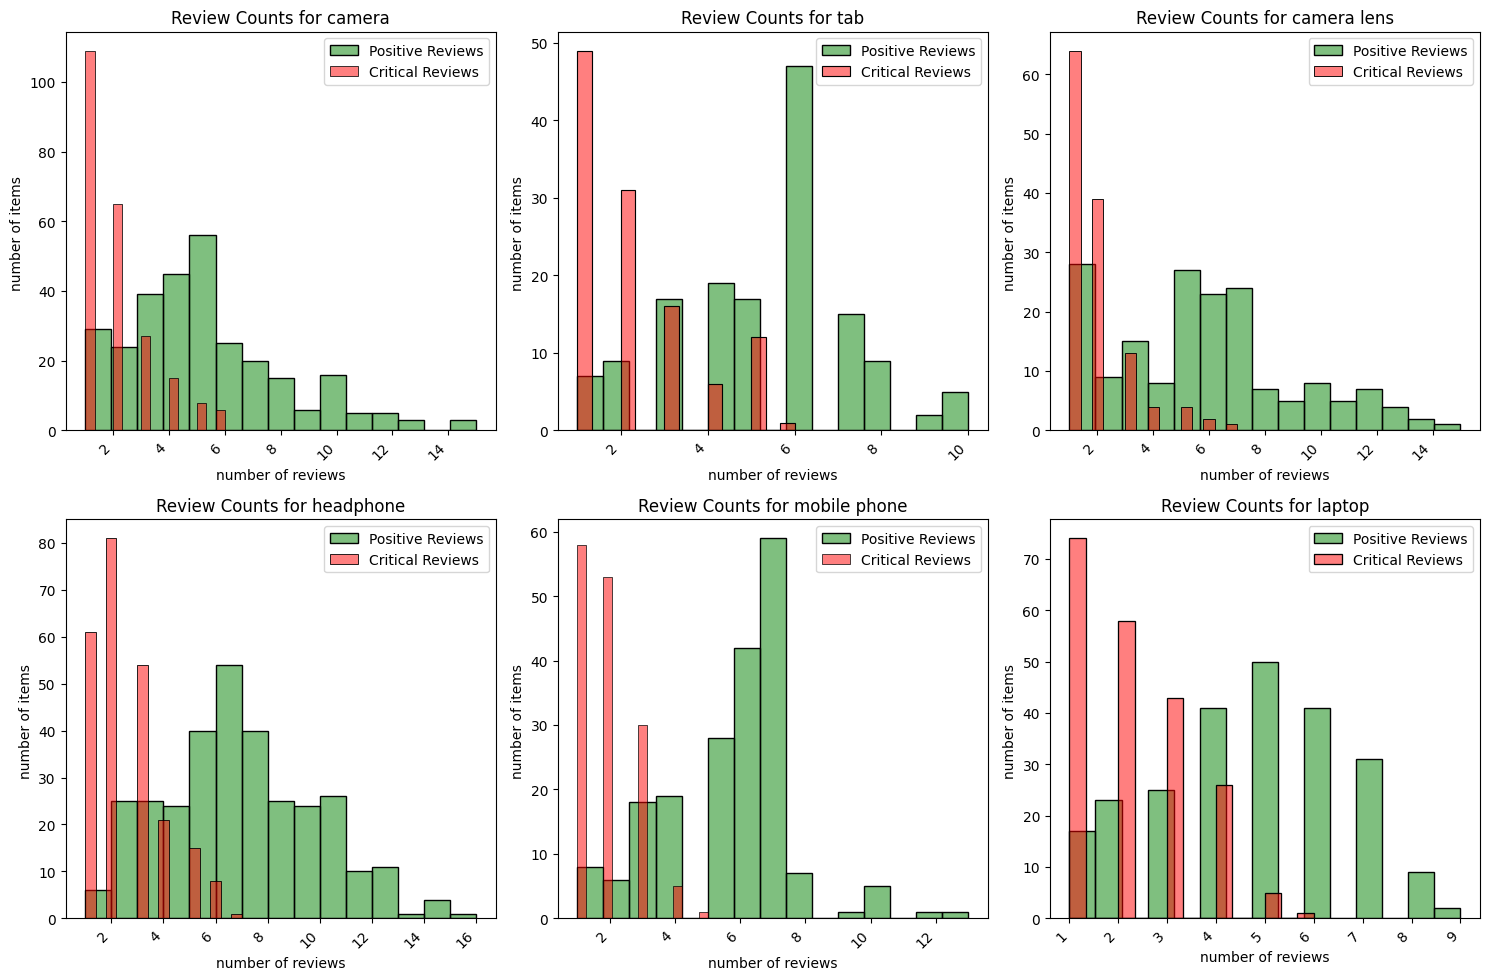

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i in range(len(item_types)):
    row = i // 3  
    col = i % 3   
    
    item_data = df[df['item'] == item_types[i]]
    
    sns.histplot(item_data[item_data['positive_count'] != 0]['positive_count'], bins=15, ax=axes[row, col], color='green', alpha=0.5, label='Positive Reviews')
    sns.histplot(item_data[item_data['critical_count'] != 0]['critical_count'], bins=15, ax=axes[row, col], color='red', alpha=0.5, label='Critical Reviews')
    
    axes[row, col].set_title(f'Review Counts for {item_types[i]}')
    axes[row, col].set_xlabel('number of reviews')
    axes[row, col].set_ylabel('number of items ')
    axes[row, col].legend()  
    
    plt.setp(axes[row, col].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('review_counts.png')
plt.show()

* Number of critical reviews per item is likely to be lesser but is seen in almost all the items
* graph for positive reviews is an even spread in most of the cases meaning that items generally have more number of positive reviews per critical review

## Histogram plot of review lengths per item type

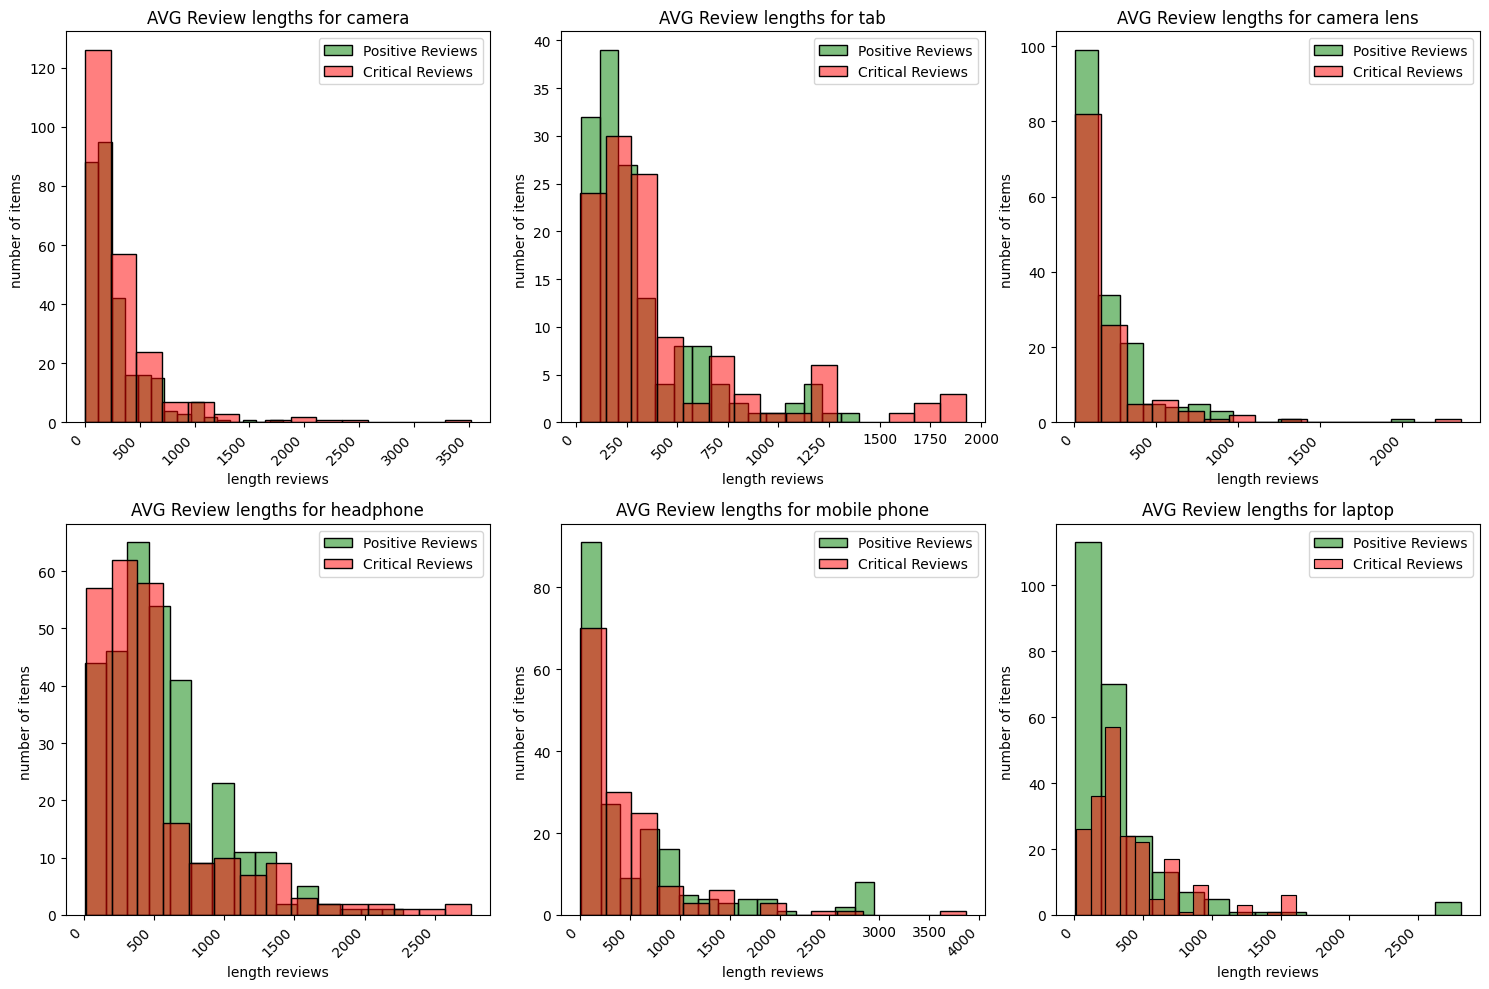

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i in range(len(item_types)):
    row = i // 3  
    col = i % 3   
    
    item_data = df[df['item'] == item_types[i]]
    
    sns.histplot(item_data[item_data['avg_p_review_len'] != 0]['avg_p_review_len'], bins=15, ax=axes[row, col], color='green', alpha=0.5, label='Positive Reviews')
    sns.histplot(item_data[item_data['avg_c_review_len'] != 0]['avg_c_review_len'], bins=15, ax=axes[row, col], color='red', alpha=0.5, label='Critical Reviews')
    
    axes[row, col].set_title(f'AVG Review lengths for {item_types[i]}')
    axes[row, col].set_xlabel('length reviews')
    axes[row, col].set_ylabel('number of items ')
    axes[row, col].legend()  
    
    plt.setp(axes[row, col].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('avg_review_length.png')
plt.show()

##### According to me this viz is purely subjective and may not alighn with pattern in some cases
* Negative reviews tend to have more lengths in general
* Positive reviews are comparatively short and generally more in number

#### Calculating the ratio between the positive review count to critical ones for every item

In [12]:
for index, row in df.iterrows():
    p_count = row['positive_count']
    c_count = row['critical_count']
    if p_count == 0:
        p_count=1
    if c_count == 0:
        c_count=1
    df.loc[index,'positive_to_critical_count'] = p_count/c_count

## Histplot for items per item type on basis of positive ratio to critical ratio count for a specific item

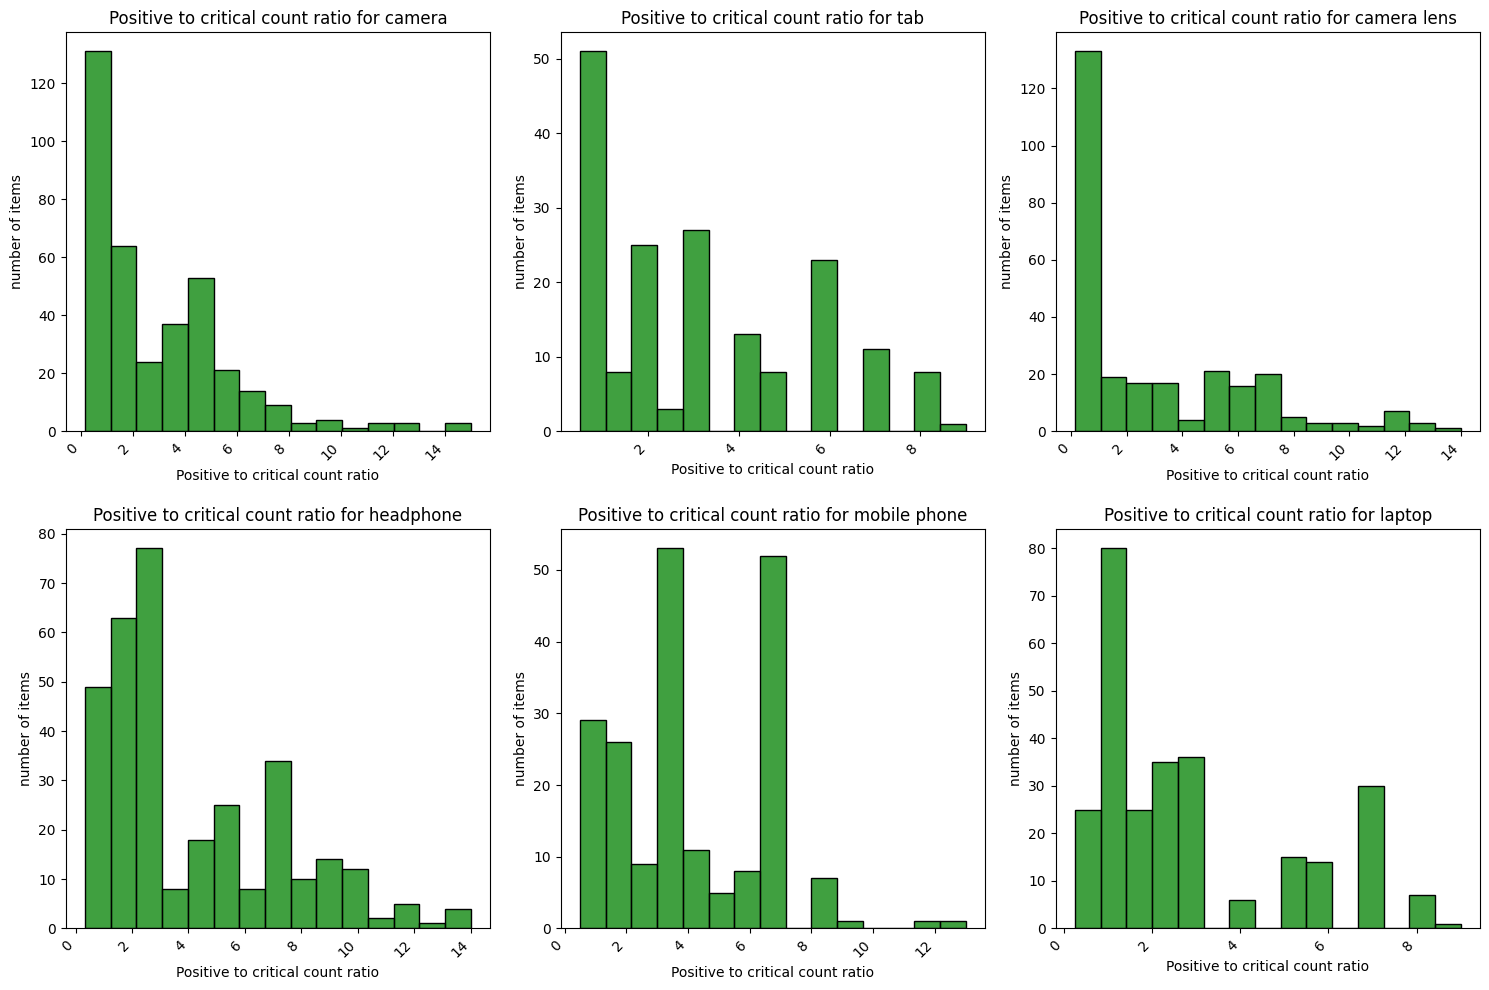

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i in range(len(item_types)):
    row = i // 3  
    col = i % 3   
    
    item_data = df[df['item'] == item_types[i]]
    
    sns.histplot(item_data['positive_to_critical_count'], bins=15, ax=axes[row, col], color='green')
    
    axes[row, col].set_title(f'Positive to critical count ratio for {item_types[i]}')
    axes[row, col].set_xlabel('Positive to critical count ratio')
    axes[row, col].set_ylabel('number of items')
    
    plt.setp(axes[row, col].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('positive_to_critical.png')
plt.show()

* Catogories related to camera tech shows the highest shift of this distribution towards 1 meaning that customers are not satisfied with these products
* Mobile-Phone and laptop Section shows the highest satisfaction as the raio is more towards the higher numbers and the low ratio score is far less than others 

## Countplot for Number of items for price-category for specific item types

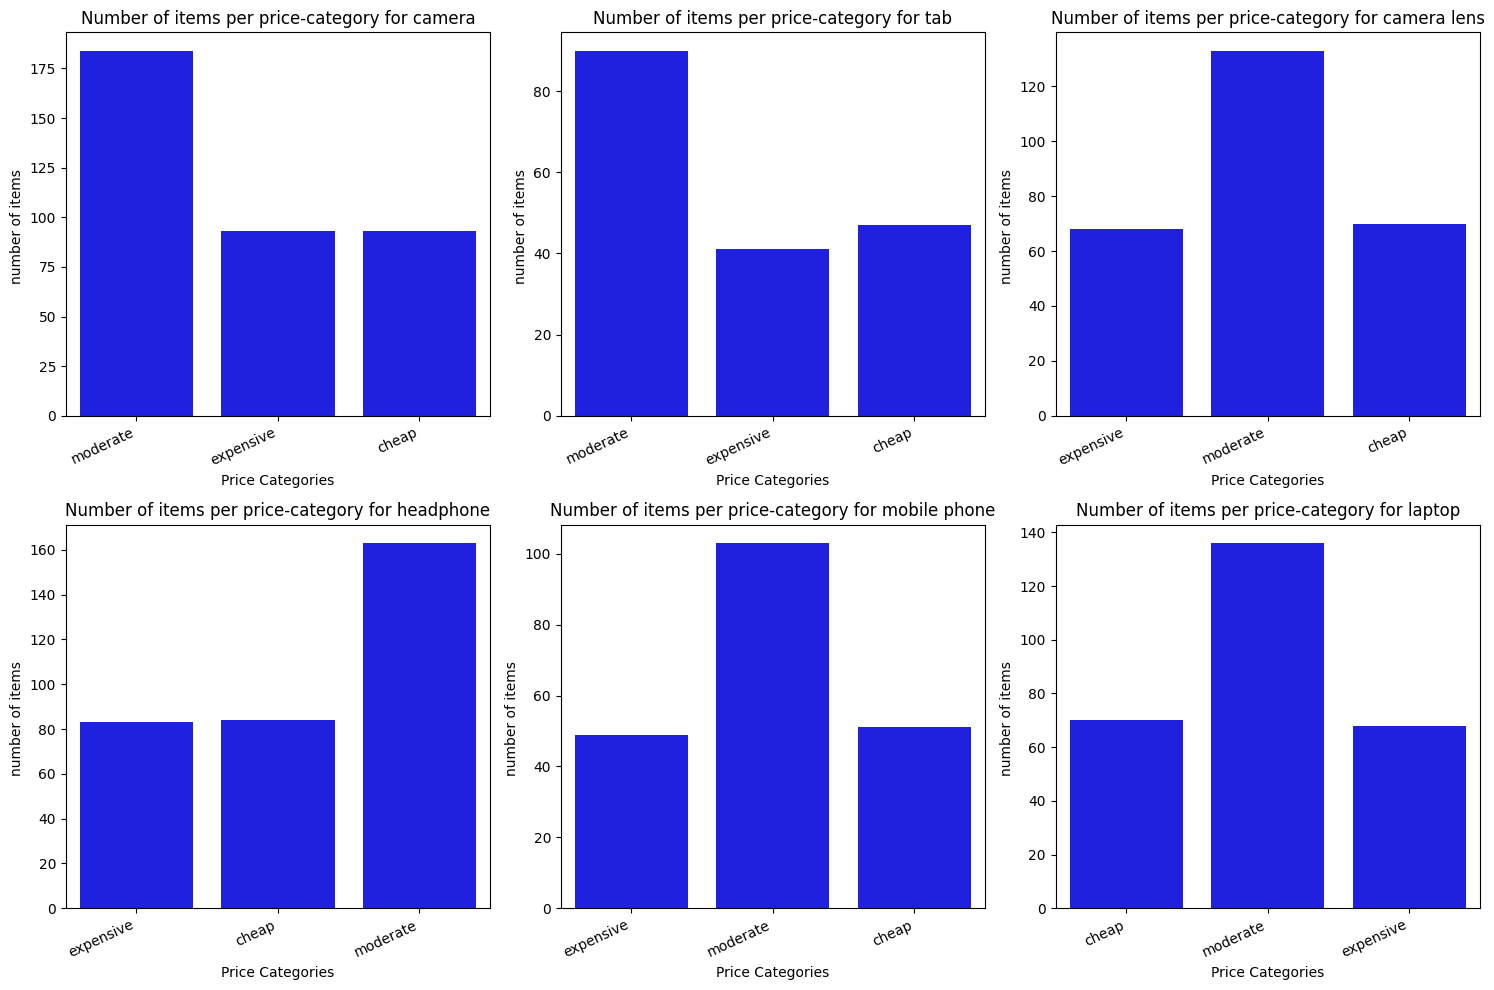

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i in range(len(item_types)):
    row = i // 3  
    col = i % 3   
    
    item_data = df[df['item'] == item_types[i]]
    
    sns.countplot(x = item_data['price_category'], ax=axes[row, col], color='b')
    
    axes[row, col].set_title(f'Number of items per price-category for {item_types[i]}')
    axes[row, col].set_xlabel('Price Categories')
    axes[row, col].set_ylabel('number of items ')
    
    plt.setp(axes[row, col].get_xticklabels(), rotation=25, ha='right')

plt.tight_layout()
plt.savefig('items_per_price_category.png')
plt.show()

# Conclusion

### Price distribution
* Avg prices for each category are as follows:
 1. Cameras->33,630 rupees
 2. Tabs->33,630 rupees
 3. Camera lenses and accessories->33,630 rupees
 4. Headphones->33,630 rupees
 5. Mobile phones ->33,630 rupees
 6. Laptops->33,630 rupees

* for each distribution, almost all categories were right-skewed except for the headphones category where some items pull the average and median closer. These items do act as outliers in the prices column.

### Review Counts per Item
* The number of critical reviews tends to be less for a specific item but generally  items tend to have at least a single critical in a quarter of the cases
* Camera and Headphones are the items that see a sudden increment in the number of items with more than 4 critical reviews, far more with respect to others.
* The headphones section sees the most number of positive reviews with a good bell shape distribution in this numerical analysis category, whereas the Tab section faces a shortage for the same 

### Avg review lengths
* The mobile phone category sees the longest-written critical review
* Camera stands at the top with the most items containing short critical reviews
* The headphones section has the critical review length graph distributed towards the right, more than any category depicting that there are increasingly more items that see a longer critical feedback which is justified as these products have the least electronic integrity.

### Positive to Critical Ratio plot
* The camera and lens category depicts the highest dissatisfaction rate are there are more than 100 items in each case where the ratio stands a solid one.
* Whereas for the mobile phones and laptops, this ratio tells a opposite story, conveying a more positive feedback-centric items


### Number of items per price category
* This plot is subjective to the prices of the categories